# Job Shop Problem (JSP)

1. GA алгоритм
2. Точный алгоритм, размерность 2xN

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Genetic Algorithm

In [8]:
from ga import genetic_search
from estimator import estimate

In [26]:
n, m = 50, 15

# generate random JSP
random.seed(42)
sol = []

for j in range(n):
    for i in range(m):
        sol.append((j, i, random.randint(1, 7)))

# solution from GA
random.seed(42)
best_sol, best_times = genetic_search(sol, n, m, epoches=1000, levels=5, 
                            alive=16, count=3, early_stopping=50, verbose=50)
print('Best time:', estimate(best_sol, n, m))

Epoch: 50/1000; Best sol: 758
Epoch: 100/1000; Best sol: 641
Epoch: 150/1000; Best sol: 584
Epoch: 200/1000; Best sol: 549
Epoch: 250/1000; Best sol: 542
Epoch: 300/1000; Best sol: 528
Epoch: 350/1000; Best sol: 524
Epoch: 400/1000; Best sol: 519
Epoch: 450/1000; Best sol: 514
Epoch: 500/1000; Best sol: 512
Epoch: 550/1000; Best sol: 507
Epoch: 600/1000; Best sol: 505
Early stopping!
Best time: 505


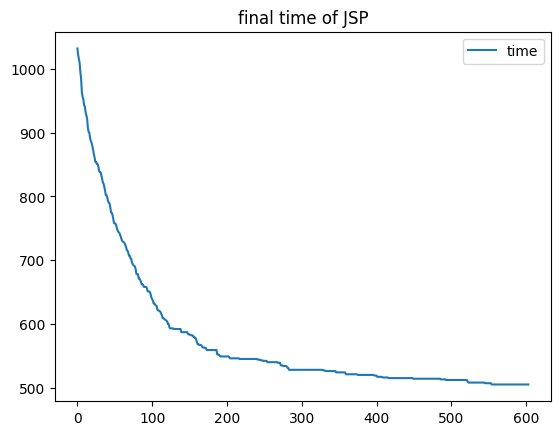

In [27]:
plt.plot(best_times, label='time')
plt.title('final time of JSP')
plt.legend()
None

Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early st

Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early stopping!
Early st

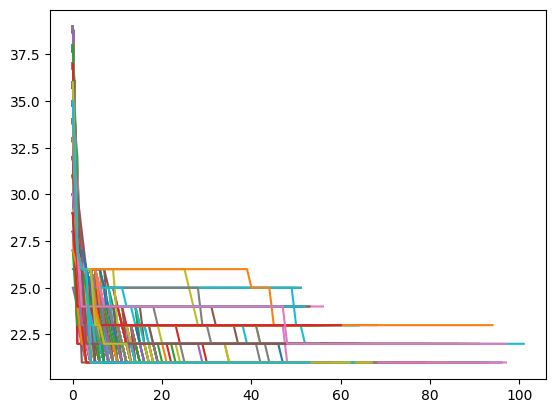

In [22]:
# generate random JSP
trajectories = []


random.seed(42)
sol = []

for j in range(n):
    for i in range(m):
        sol.append((j, i, random.randint(1, 7)))
       
random.seed(42)
for i in range(1000):
    n, m = 5, 3

    best_sol, best_times = genetic_search(sol, n, m, epoches=300, levels=5, 
                                alive=12, count=5, early_stopping=50, verbose=False)
    trajectories.append(best_times)
    plt.plot(best_times)

In [35]:
# percentiles

final_times = [t[-1] for t in trajectories]

eps = 0.05
not_opt = [t[-1] for t in trajectories if t[-1] > 21 * (1 + eps)]

print(f'алгоритм не сошелся к окрестности оптимума в {len(not_opt) / len(final_times) * 100}% случаях')

алгоритм не сошелся к окрестности оптимума в 7.1% случаях


(array([513.,   0., 416.,   0.,   0.,  59.,   0.,   9.,   0.,   3.]),
 array([21. , 21.4, 21.8, 22.2, 22.6, 23. , 23.4, 23.8, 24.2, 24.6, 25. ]),
 <BarContainer object of 10 artists>)

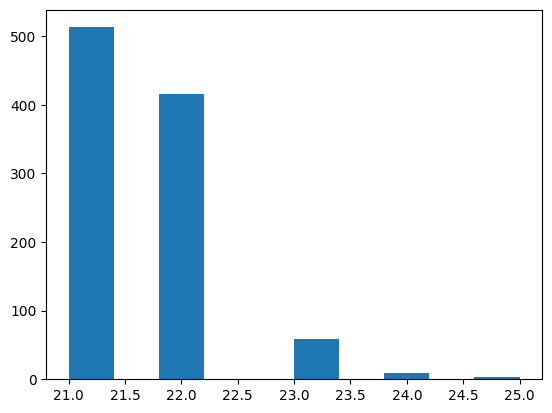

In [36]:
plt.hist(final_times)

In [24]:
from copy import deepcopy

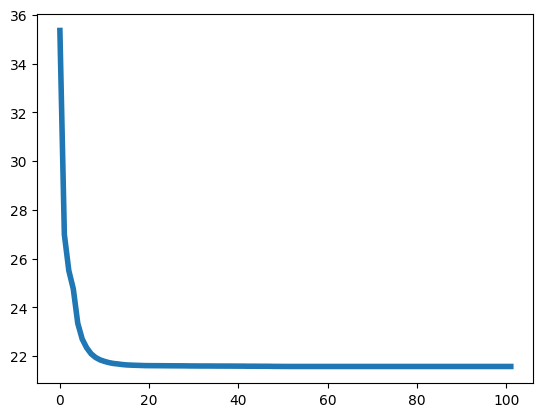

In [37]:
m = 0

ttt = deepcopy(trajectories)

for t in ttt:
    m = max(len(t), m)

for t in ttt:
    if len(t) < m:
        r = m - len(t)
        t.extend([t[-1]] * r)

ttt = np.array(ttt)
mean_trajectory = np.mean(ttt, axis=0)
plt.plot(mean_trajectory, linewidth=4, label='mean trajectory')

## Точный алгоритм

Job Shop Scheduling Problem (JSP) - это NP-полная задача комбинаторной оптимизации, и точное решение для больших инстанций может потребовать значительных вычислительных ресурсов. Однако для относительно небольших инстанций, например, с двумя машинами и небольшим количеством работ (n), можно применить точные методы решения. Вот базовая идея:

1. **Определение переменных решения:** Каждая переменная решения `x[i, j, k]` равна 1, если задача `i` выполняется на машине `j` в момент времени `k`, и 0 в противном случае. Здесь `i` - номер задачи, `j` - номер машины, `k` - момент времени.

2. **Определение целевой функции:** Целью является минимизация суммарного времени завершения выполнения всех задач:
   $\sum_{j=1}^{n} \sum_{i=1}^{2} \sum_{k=1}^{T} processing_times[j][i] * x[j, i, k] = 1$.

3. **Ограничения:**
   - Каждая задача должна быть выполнена ровно один раз:
   $\forall j, i: \sum_{k=1}^{T} x[j, i, k] = 1$.
   - Каждая машина должна выполнять только одну задачу в каждый момент времени:
   $\forall i, k: \sum_{j=1}^{n} x[j, i, k] = 1$.

4. **Решение задачи:** Применение линейного программирования (LP) или целочисленного программирования (IP) для решения задачи.

5. **Интерпретация результата:** После решения задачи, переменные `x[i, j, k]` будут содержать информацию о том, какие задачи выполняются на каких машинах в каждый момент времени.

In [5]:
from exact_alg import solve_jsp

In [6]:
n, m = 5, 2

# generate random Job Shop scheduling task
random.seed(42)
sol = []
processing_times = []

for j in range(n):
    l = []
    for i in range(m):
        t = random.randint(1, 7)
        sol.append((j, i, t))
        l.append(t)
    processing_times.append(l)

# solution from MILP
random.seed(42)
best_sol = solve_jsp(n, m, processing_times, verbose=False)
if not best_sol:
    print('No optimal solution')
print('Time:', estimate(best_sol, n, m))

Time: 19
